This code will help you do quick coordinate conversions and dwnld/view images based on their coordinates.

In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:100% !important;}</style>'))


In [2]:
#convert hmsdms to degrees
from astropy import units as u
from astropy.coordinates import SkyCoord
r='03 29 41.2409'
d='-02 12 55.922'
crd = SkyCoord(r[0:2]+"h"+r[3:5]+'m'+r[6:12]+'s',d[0:3]+"d"+d[4:6]+'m'+d[7:11]+'s')
print (crd.ra.degree, crd.dec.degree)

52.421833333333325 -2.215527777777778


In [3]:
#convert degrees to hmsdms
a= SkyCoord(245.3426046,38.1684351, unit='deg') 
a.to_string('hmsdms')


'16h21m22.2251s +38d10m06.3664s'

In [4]:
#convert degrees to hmsdms
a= SkyCoord(251.2662542,1.6683825, unit='deg') 
a.to_string('hmsdms')


'16h45m03.901s +01d40m06.177s'

In [5]:
#convert degrees to hmsdms
a= SkyCoord(52.4200531,-2.2217470, unit='deg') 
a.to_string('hmsdms')


'03h29m40.8127s -02d13m18.2892s'

In [6]:
#convert degrees to hmsdms
a= SkyCoord(41.3617431,-53.0698493, unit='deg') 
a.to_string('hmsdms')


'02h45m26.8183s -53d04m11.4575s'

In [1]:
'''this code allows you to download an image based on ra and dec and also determine how many bands it is available in
Will only look for PRODUCT calibrated co-added images'''
import subprocess
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from daomop.storage import tap_query ##_251.26625423401939_1.6683825966091756
import time
start=time.time()
CUTOUT_PATH ="candidate2_814.fits"


ra = 35.273747
dec =  35.937809

grade="B"

def get_filenames(ra, dec): #0.001
    query = '''SELECT caom2.Plane.publisherID, caom2.Plane.planeURI
    FROM caom2.observation 
    JOIN caom2.plane ON caom2.observation.obsID = caom2.plane.obsID 
    WHERE CONTAINS( CIRCLE('ICRS',''' + str(ra) + ',' +str(dec) + ''',0.001), caom2.plane.position_bounds)=1 
    AND caom2.observation.collection = 'HST' 
    AND caom2.observation.instrument_name = 'ACS/WFC' 
    AND caom2.Plane.energy_bandpassName ='F814W'
    ''' #'F814W' F606W,F850W F475WAND   AND 
    
    out_query = tap_query(query)

    print(out_query)

    '''store the pubID and filenames'''
    success=False
    for entry in range(len(out_query["publisherID"])):#
#         if (True):
        if (("0-"  in out_query["publisherID"][entry]) and ("PRODUCT"  in out_query["publisherID"][entry])) :
            success=True
            start = out_query["publisherID"][entry].find('HST?') + 4 #add 4 to get to the and of the HST?
            end = out_query["publisherID"][entry].find('/j', start)
            print(out_query["publisherID"][entry][start:end])
            try:
                subprocess.check_output(["wget", "-O", CUTOUT_PATH,
                                 "http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/cutout?uri=mast:HST/product/"+
                                 str(out_query["publisherID"][entry][start:end])+"_drc.fits&cutout=Circle+ICRS+" + str(ra) + "+" +
                                 str(dec) + "+0.001"])#0.002
                break
            except:
                print('fail')
                
    if success==False: print('couldnt find filename')
        
def count_bands(ra, dec):
    #get all the results (from all bands) 
    query = '''SELECT caom2.Plane.publisherID, caom2.Plane.energy_bandpassName 
    FROM caom2.observation 
    JOIN caom2.plane ON caom2.observation.obsID = caom2.plane.obsID 
    WHERE CONTAINS( CIRCLE('ICRS',''' + str(ra) + ',' +str(dec)  + ''',0.002), caom2.plane.position_bounds)=1 
    AND caom2.observation.collection = 'HST' 
    AND caom2.observation.instrument_name = 'ACS/WFC'   
    '''
    
    out_query = tap_query(query)
    
    #check to see if there are multiple object ids that are in differnet filters
    filters=[]
    for entry in range(len(out_query["publisherID"])):
        #first check if the entry is PRODUCT co-added (SHOULD I INCLUDE ALL RESULTS AND PARSE LATER???)
        if (("0-" in out_query["publisherID"][entry]) and ("PRODUCT" in out_query["publisherID"][entry])):
            if out_query['energy_bandpassName'][entry] not in filters: # then check if it is a new filter
                filters.append(out_query['energy_bandpassName'][entry])
    print(filters)

                
        
get_filenames(ra,dec)
print(time.time()-start)
count_bands(ra,dec)

data, hdr = fits.getdata(CUTOUT_PATH, 1, header=True)
plt.imshow(np.log10(data+1)),hdr['CRVAL1'],hdr['CRVAL2'],hdr ['PHOTMODE']

publisherID planeURI
----------- --------
couldnt find filename
0.689740896225
['CLEAR1L;F814W']


IOError: [Errno 2] No such file or directory: 'candidate2_814.fits'

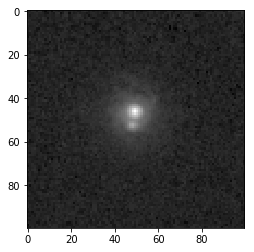

In [230]:
#view a samll window of the original image
from astropy.visualization import (ZScaleInterval, ImageNormalize)
from astropy.nddata.utils import Cutout2D
left = float(50)
right=float(150)
centered_cut = Cutout2D(data,(left, right), (100, 100)).data
norm = ImageNormalize(data, interval = ZScaleInterval())
# plt.imshow((centered_cut),norm=norm, cmap='gray')
plt.imshow(np.log10(centered_cut+0.1),cmap='gray')


In [231]:
#save as jpg
from PIL import Image
from sklearn.preprocessing import minmax_scale
centered_cut = Cutout2D(data,(left, right), (100, 100))
# tmp_lens = (centered_cut.data).reshape(-1,)     
tmp_lens = np.log10(centered_cut.data+0.1).reshape(-1,)     

new = np.zeros( tmp_lens.shape,'uint8')

tmp_lens = minmax_scale(tmp_lens, feature_range = (0, 255))  
for i in range(len(tmp_lens)):
    new[i] = int(round(tmp_lens[i]))
centered_cut.data = new.reshape(centered_cut.data.shape[0],centered_cut.data.shape[1])

img = Image.fromarray(centered_cut.data)
img.save('candidtate_'+"A"+"_"+str(ra)+"_"+str(dec)+".jpg")

In [40]:
#save the tiled image with an appropriate fits header
from astropy.wcs import WCS
wcs1 = WCS(hdr)
centered_cut = Cutout2D(data,(float(190), float(180)), (100, 100),wcs=wcs1)

hdu1 = fits.PrimaryHDU(data=centered_cut.data, header=centered_cut.wcs.to_header())
hdu1.writeto('candidate_3_F814W.fits', overwrite =True) 

In [52]:
hdr 

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  301 / length of data axis 1                          
NAXIS2  =                  301 / length of data axis 2                          
PCOUNT  =                    0 /                                                
GCOUNT  =                    1 / one data group (required keyword)              
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'SCI     '           / extension name                                 
EXTVER  =                    1                                                  
BUNIT   = 'ELECTRONS/S'     

In [50]:
hdr

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  301 / length of data axis 1                          
NAXIS2  =                  301 / length of data axis 2                          
PCOUNT  =                    0 /                                                
GCOUNT  =                    1 / one data group (required keyword)              
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'SCI     '           / extension name                                 
EXTVER  =                    1                                                  
BUNIT   = 'ELECTRONS/S'     

In [ ]:
import subprocess

DWNLD_PATH = "/home/robbie/repos/HSTLens/CC_batch_processing/full/full_"+str(0)

subprocess.check_output(["wget", "-O",DWNLD_PATH+ ".fits" ,
                         "http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/MAST/HST/product/"+
                         'jdn024010'+"_drz.fits"]) 